# Sentence classification

In this tutorial we will try to predict whether an SMS is a spam or not. To train our model, we will use the `SMSSpam` dataset. This dataset is unbalanced, there is only 13.4% spam. Let's look at the data:

In [1]:
from river import datasets

datasets.SMSSpam()

SMS Spam Collection dataset.

The data contains 5,574 items and 1 feature (i.e. SMS body). Spam messages represent
13.4% of the dataset. The goal is to predict whether an SMS is a spam or not.

      Name  SMSSpam                                                                              
      Task  Binary classification                                                                
   Samples  5,574                                                                                
  Features  1                                                                                    
    Sparse  False                                                                                
      Path  /Users/home/river_data/SMSSpam/SMSSpamCollection                                     
       URL  https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
      Size  466.71 KB                                                                            
Downloaded  True      

In [2]:
from pprint import pprint

X_y = datasets.SMSSpam()

for x, y in X_y:
    pprint(x)
    print(f'Spam: {y}')
    break

{'body': 'Go until jurong point, crazy.. Available only in bugis n great world '
         'la e buffet... Cine there got amore wat...\n'}
Spam: False


Let's start by building a simple model like a Naive Bayes classifier. We will first preprocess the sentences with a TF-IDF transform that our model can consume. Then, we will measure the accuracy of our model with the AUC metric. This is the right metric to use when the classes are not balanced. In addition, the Naive Bayes models can perform very well on unbalanced datasets and can be used for both binary and multi-class classification problems.

In [3]:
from river import feature_extraction
from river import naive_bayes
from river import metrics

def extract_body(x):
    """Extract the body of the sms."""
    return x['body']

X_y = datasets.SMSSpam()

model = (
    extract_body | 
    feature_extraction.TFIDF() | 
    naive_bayes.BernoulliNB(alpha=0)
)

metric = metrics.ROCAUC()
cm = metrics.ConfusionMatrix()

for x, y in X_y:
    
    y_pred = model.predict_one(x)
    
    if y_pred is not None:
        metric.update(y_pred=y_pred, y_true=y)
        cm.update(y_pred=y_pred, y_true=y)
    
    model.learn_one(x, y)
    
metric

ROCAUC: 0.929296

The confusion matrix:

In [4]:
cm

           False    True
   False    4809      17
    True     103     644

The results are quite good with this first model.

Since we are working with an unbalanced dataset, we can use the `imblearn` module to rebalance the classes of our dataset. For more information about the `imblearn` module, you can find a dedicated tutorial [here](../imbalanced-learning).

In [5]:
from river import imblearn

X_y = datasets.SMSSpam()

model = (
    extract_body | 
    feature_extraction.TFIDF() | 
    imblearn.RandomUnderSampler(
        classifier=naive_bayes.BernoulliNB(alpha=0),
        desired_dist={0: .5, 1: .5},
        seed=42
    )
)

metric = metrics.ROCAUC()
cm = metrics.ConfusionMatrix()

for x, y in X_y:
    
    y_pred = model.predict_one(x)
    
    if y_pred is not None:
        metric.update(y_pred=y_pred, y_true=y)
        cm.update(y_pred=y_pred, y_true=y)
    
    model.learn_one(x, y)
    
metric

ROCAUC: 0.951728

The `imblearn` module improved our results. Not bad! We can visualize the pipeline to understand how the data is processed.

The confusion matrix:

In [6]:
cm

           False    True
   False    4624     201
    True      41     706

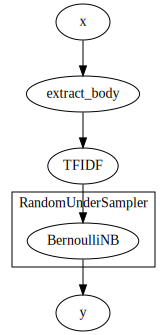

In [7]:
model.draw()

Now let's try to use logistic regression to classify messages. We will use different tips to make my model perform better. As in the previous example, we rebalance the classes of our dataset. The logistics regression will be fed from a TF-IDF.

In [8]:
from river import linear_model
from river import optim
from river import preprocessing

X_y = datasets.SMSSpam()

model = (
    extract_body | 
    feature_extraction.TFIDF() | 
    preprocessing.Normalizer() | 
    imblearn.RandomUnderSampler(
        classifier=linear_model.LogisticRegression(
            optimizer=optim.SGD(.9), 
            loss=optim.losses.Log()
        ),
        desired_dist={0: .5, 1: .5},
        seed=42
    )
)

metric = metrics.ROCAUC()
cm = metrics.ConfusionMatrix()

for x, y in X_y:
    
    y_pred = model.predict_one(x)

    metric.update(y_pred=y_pred, y_true=y)
    cm.update(y_pred=y_pred, y_true=y)
    
    model.learn_one(x, y)
    
metric

ROCAUC: 0.946039

The confusion matrix:

In [9]:
cm

           False    True
   False    4655     172
    True      54     693

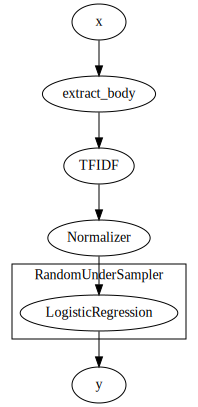

In [10]:
model.draw()

The results of the logistic regression are quite good but still inferior to the naive Bayes model.

Let's try to use word embeddings to improve our logistic regression. Word embeddings allow you to represent a word as a vector. Embeddings are developed to build semantically rich vectors. For instance, the vector which represents the word **python** should be close to the vector which represents the word **programming**. We will use [spaCy](https://spacy.io/) to convert our sentence to vectors. spaCy converts a sentence to a vector by calculating the average of the embeddings of the words in the sentence.

You can download pre-trained embeddings in many languages. We will use English pre-trained embeddings as our SMS are in English.

The command below allows you to download the pre-trained embeddings that spaCy makes available. More informations about spaCy and its installation may be found here [here](https://spacy.io/usage).

```sh
python -m spacy download en_core_web_sm
```

Here, we create a custom transformer to convert an input sentence to a dict of floats. We will integrate this transformer into our pipeline.

In [11]:
import spacy

from river.base import Transformer

class Embeddings(Transformer):
    """My custom transformer, word embedding using spaCy."""
    
    def __init__(self):
        self.embeddings = spacy.load('en_core_web_sm')
        
    def transform_one(self, x, y=None):
        return {dimension: xi for dimension, xi in enumerate(self.embeddings(x).vector)}

Let's train our logistic regression:

In [12]:
X_y = datasets.SMSSpam()

model = (
    extract_body | 
    Embeddings() | 
    preprocessing.Normalizer() |
    imblearn.RandomOverSampler(
        classifier=linear_model.LogisticRegression(
            optimizer=optim.SGD(.5), 
            loss=optim.losses.Log()
        ),
        desired_dist={0: .5, 1: .5},
        seed=42
    )
)

metric = metrics.ROCAUC()
cm = metrics.ConfusionMatrix()

for x, y in X_y:
    
    y_pred = model.predict_one(x)
    
    metric.update(y_pred=y_pred, y_true=y)
    cm.update(y_pred=y_pred, y_true=y)
    
    model.learn_one(x, y)

metric

ROCAUC: 0.91568

The confusion matrix:

In [13]:
cm

           False    True
   False    4517     310
    True      78     669

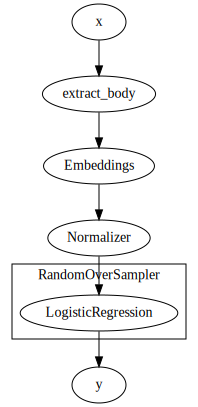

In [14]:
model.draw()

The results of the logistic regression using spaCy embeddings are lower than those obtained with TF-IDF values. We could surely improve the results by cleaning up the text. We could also use embeddings more suited to our dataset. However, on this problem, the logistic regression is not better than the Naive Bayes model. No free lunch today.